# 12. Cluster Analysis


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import seaborn as sns


In [34]:
%run "01.Recommendation_Loading.ipynb"

################  Recommendations (all data, positive recommendations only) ################
Users: 12,663,134
Games: 37,419
Number of users 2,000
First five users id [11187923 12792392 11703922  9531989 11022607]
################  Recommendations (Sample) ################
Minimum number of recommendations to be included in the sample: 20
Number of randomly selected users: 2000
Users: 1,991
Games: 11,366
################ User-Game Matrix ################
Number of Rows: 1,992
Numbeer of Columns: 11,367
Number of stored values: 74,405


In [35]:
%run "04.Games_Exploration.ipynb"


There are 50872 distinct games
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   app_id       50872 non-null  int64 
 1   description  50872 non-null  object
 2   tags         50872 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
There are 50872 distinct games
There are 441 tags
The top 10 tags with their respective count are: [('Indie', 27957), ('Singleplayer', 22566), ('Action', 21897), ('Adventure', 20183), ('Casual', 17844)]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49628 entries, 10 to 2515460
Columns: 441 entries, 1980s to eSports
dtypes: int8(441)
memory usage: 21.3 MB


In [36]:
matrix_games_tags = matrix_games_tags.reset_index()
games_to_keep = recommendations.app_id.unique()
matrix_games_tags = matrix_games_tags[matrix_games_tags["app_id"].isin(games_to_keep)]
matrix_games_tags.head()


tags,app_id,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,...,Well-Written,Werewolves,Western,Wholesome,Word Game,World War I,World War II,Wrestling,Zombies,eSports
0,10,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,20,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,40,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
games_idx = pd.read_csv('matrix/games_idx.csv')
games_idx.head()


,app_id,app_id_categorical
0,337000,2500
1,381210,3122
2,1144200,8576
3,292030,1894
4,15120,238


In [38]:
matrix_games_tags = pd.merge(games_idx, matrix_games_tags, left_on="app_id", right_on="app_id").drop(columns="app_id")
matrix_games_tags.head()


,app_id_categorical,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,...,Well-Written,Werewolves,Western,Wholesome,Word Game,World War I,World War II,Wrestling,Zombies,eSports
0,2500,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,238,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9629,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1570,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
matrix_games_tags = pd.merge(recommendations, matrix_games_tags, left_on="app_id_categorical", right_on="app_id_categorical")
matrix_games_tags.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,user_id_categorical,app_id_categorical,...,Well-Written,Werewolves,Western,Wholesome,Word Game,World War I,World War II,Wrestling,Zombies,eSports
0,337000,19,6,2021-07-11,1,26.0,12039,38767195,0,2500,...,0,0,0,0,0,0,0,0,0,0
1,337000,0,0,2019-08-20,1,59.2,725645,14952611,77,2500,...,0,0,0,0,0,0,0,0,0,0
2,337000,0,0,2022-10-30,1,330.8,1396964,17137785,146,2500,...,0,0,0,0,0,0,0,0,0,0
3,337000,0,0,2016-08-26,1,23.3,2152134,19289194,197,2500,...,0,0,0,0,0,0,0,0,0,0
4,337000,0,0,2016-08-26,1,70.9,2498931,17101142,217,2500,...,0,0,0,0,0,0,0,0,0,0


In [40]:
matrix_games_tags = matrix_games_tags.groupby("user_id_categorical").max()
matrix_games_tags.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id,app_id_categorical,1980s,...,Well-Written,Werewolves,Western,Wholesome,Word Game,World War I,World War II,Wrestling,Zombies,eSports
user_id_categorical,,,,,,,,,,,,,,,,,,,,,
0,1782210,100,80,2022-03-28,1,41.0,12039,41042676,10847,0,...,0,0,0,0,0,0,1,0,0,0
1,1139900,5,2,2022-06-14,1,106.5,20798,39854648,8548,0,...,0,0,0,0,0,1,1,0,1,0
2,1808360,2,0,2022-02-05,1,33.6,24787,31123930,10906,0,...,0,0,0,0,0,1,1,0,0,0
3,1853200,2,2,2022-12-04,1,130.4,39739,41086653,10991,0,...,0,0,0,0,0,1,1,0,0,0
4,1570070,13,5,2022-06-04,1,203.7,52992,39699084,10349,1,...,0,0,0,0,0,0,0,0,0,0


In [41]:
columns_to_drop = list(recommendations.columns)
columns_to_drop.remove("user_id_categorical")
columns_to_drop

['app_id',
 'helpful',
 'funny',
 'date',
 'is_recommended',
 'hours',
 'user_id',
 'review_id',
 'app_id_categorical']

In [42]:
matrix_games_tags = matrix_games_tags.drop(columns=columns_to_drop)
matrix_games_tags

,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,...,Well-Written,Werewolves,Western,Wholesome,Word Game,World War I,World War II,Wrestling,Zombies,eSports
user_id_categorical,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,1,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,1,1,0,1,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
4,1,1,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,0,1,0,1,0,1,0,1,0,1,...,1,0,0,1,0,0,0,0,0,0
1987,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1988,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [43]:
matrix_games_tags.T

user_id_categorical,0,1,2,3,4,5,6,7,8,9,...,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990
1980s,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1990's,0,1,0,0,1,1,0,0,1,0,...,1,0,1,0,0,1,1,0,1,1
2.5D,1,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2D,1,0,1,0,1,1,1,1,1,1,...,1,0,1,0,1,1,1,0,1,1
2D Fighter,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
World War I,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
World War II,1,1,1,1,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
Wrestling,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zombies,0,1,0,0,0,1,1,0,0,1,...,1,0,1,1,0,0,1,1,1,0


## Principal Component Analysis

In [44]:
# Standardize the data
scaler = StandardScaler()
game_user_matrix_standardized = scaler.fit_transform(matrix_games_tags.T)

In [45]:
# Specify the number of components (dimensions) you want after reduction
num_components = 10

# Apply PCA
pca = PCA(n_components=num_components)
game_tags_reduced = pca.fit_transform(game_user_matrix_standardized)

# Print the reduced dimensions for each game tag
print("Reduced Game Tags Dimensions:\n", game_tags_reduced)

game_tags_reduced.shape

Reduced Game Tags Dimensions:
 [[  0.5047312   -2.45003828  -2.19796052 ...   9.52829596   0.08728552
   -4.22574991]
 [ 12.17646662  -1.24598007  -3.59728218 ...  16.37128309  -1.67886414
   -4.47147515]
 [  7.52380558 -10.04233453   2.40278287 ...  -5.97131263   1.51949363
    3.06318352]
 ...
 [-27.33124618   1.61715316  -2.09303689 ...  -0.79188299  -2.31689134
    0.6517085 ]
 [ 36.82347638   9.73078864  -9.21026701 ...   7.43765046  -1.7929957
   -7.01348757]
 [ -2.50499374   7.32804254  -5.94578536 ...   4.86202279   2.21214837
    6.91065887]]


(441, 10)

In [46]:
comp_df = pd.DataFrame(data=game_tags_reduced, index=matrix_games_tags.T.index)
comp_df

,0,1,2,3,4,5,6,7,8,9
1980s,0.5,-2.5,-2.2,-5.4,13.8,3.1,-0.3,9.5,0.1,-4.2
1990's,12.2,-1.2,-3.6,-2.7,14.9,4.3,-1.2,16.4,-1.7,-4.5
2.5D,7.5,-10.0,2.4,2.7,7.1,-1.6,5.5,-6.0,1.5,3.1
2D,59.9,-5.2,8.8,-6.2,-3.2,-2.1,-1.5,2.3,-8.9,0.0
2D Fighter,-7.2,-1.5,-2.1,-3.2,6.6,-10.0,13.6,-1.1,-1.0,5.2
...,...,...,...,...,...,...,...,...,...,...
World War I,-18.4,5.4,-3.1,-1.8,-2.4,3.7,0.4,3.5,-2.0,-0.4
World War II,6.3,14.7,-5.9,6.7,-0.4,8.4,4.8,8.9,1.2,-3.9
Wrestling,-27.3,1.6,-2.1,-1.4,-1.6,-3.1,-1.8,-0.8,-2.3,0.7
Zombies,36.8,9.7,-9.2,1.2,8.9,1.5,-1.8,7.4,-1.8,-7.0


In [47]:
for comp in comp_df.columns:
    print("Component:", comp)
    print("Top Game Tags in this component:")
    print(comp_df[comp].sort_values(ascending=False)[:10])
    print("")

Component: 0
Top Game Tags in this component:
Singleplayer       71.3
Action             71.3
Adventure          71.0
Atmospheric        70.4
Multiplayer        70.4
Indie              69.6
Great Soundtrack   69.0
Story Rich         68.2
Co-op              67.9
Open World         67.9
Name: 0, dtype: float64

Component: 1
Top Game Tags in this component:
Military                24.7
Team-Based              23.6
Massively Multiplayer   22.4
War                     22.4
PvP                     20.2
Realistic               19.6
RTS                     19.5
Moddable                19.4
Tactical                18.6
Sandbox                 17.6
Name: 1, dtype: float64

Component: 2
Top Game Tags in this component:
Roguelike               26.5
Roguelite               24.8
Procedural Generation   22.4
Action Roguelike        21.1
Building                20.4
Management              20.2
Resource Management     19.9
Turn-Based Strategy     19.6
Dungeon Crawler         19.5
Turn-Based           

Let's assign names to each component

In [48]:
comp_df.columns = ["Adventure", "War Muliplayer", "Management", "Strategy", "Simulation",
                  "RPG","Romantic", "Driving", "Realistic", "Horror"]

In [49]:
comp_df.head()

,Adventure,War Muliplayer,Management,Strategy,Simulation,RPG,Romantic,Driving,Realistic,Horror
1980s,0.5,-2.5,-2.2,-5.4,13.8,3.1,-0.3,9.5,0.1,-4.2
1990's,12.2,-1.2,-3.6,-2.7,14.9,4.3,-1.2,16.4,-1.7,-4.5
2.5D,7.5,-10.0,2.4,2.7,7.1,-1.6,5.5,-6.0,1.5,3.1
2D,59.9,-5.2,8.8,-6.2,-3.2,-2.1,-1.5,2.3,-8.9,0.0
2D Fighter,-7.2,-1.5,-2.1,-3.2,6.6,-10.0,13.6,-1.1,-1.0,5.2


In [50]:
comp_df.columns


Index(['Adventure', 'War Muliplayer', 'Management', 'Strategy', 'Simulation',
       'RPG', 'Romantic', 'Driving', 'Realistic', 'Horror'],
      dtype='object')

In [51]:
comp_df.sort_values(by="War Muliplayer", ascending=False)

,Adventure,War Muliplayer,Management,Strategy,Simulation,RPG,Romantic,Driving,Realistic,Horror
Military,21.0,24.7,-8.3,6.4,1.6,10.9,9.1,11.7,3.5,5.3
Team-Based,22.4,23.6,-5.4,-7.6,5.6,0.5,7.3,8.6,10.7,12.4
Massively Multiplayer,22.3,22.4,-3.1,-10.6,-1.4,-1.4,9.3,8.4,9.2,1.9
War,27.3,22.4,-6.2,12.0,0.3,9.7,10.9,8.1,2.2,5.0
PvP,42.4,20.2,-1.5,-8.5,-0.2,-6.4,5.9,5.8,12.3,11.4
...,...,...,...,...,...,...,...,...,...,...
Point & Click,28.0,-20.4,0.3,-2.4,-4.9,14.7,1.8,1.2,-6.8,4.6
Interactive Fiction,3.4,-21.1,0.3,-1.8,-10.0,6.5,1.8,5.3,6.1,2.9
Emotional,15.2,-21.7,-1.2,3.9,-8.3,7.0,4.5,1.0,2.8,5.1
Mystery,31.0,-22.7,-5.3,1.3,-6.8,10.0,-4.4,2.1,4.6,7.4


In [52]:
# Function to assign each tag to the component with the highest loading
def assign_to_component(row):
    return row.idxmax()

# Apply the function to each row (tag)
comp_df['Assigned_Component'] = comp_df.apply(assign_to_component, axis=1)

# Display the resulting DataFrame with assigned components
comp_df

,Adventure,War Muliplayer,Management,Strategy,Simulation,RPG,Romantic,Driving,Realistic,Horror,Assigned_Component
1980s,0.5,-2.5,-2.2,-5.4,13.8,3.1,-0.3,9.5,0.1,-4.2,Simulation
1990's,12.2,-1.2,-3.6,-2.7,14.9,4.3,-1.2,16.4,-1.7,-4.5,Driving
2.5D,7.5,-10.0,2.4,2.7,7.1,-1.6,5.5,-6.0,1.5,3.1,Adventure
2D,59.9,-5.2,8.8,-6.2,-3.2,-2.1,-1.5,2.3,-8.9,0.0,Adventure
2D Fighter,-7.2,-1.5,-2.1,-3.2,6.6,-10.0,13.6,-1.1,-1.0,5.2,Romantic
...,...,...,...,...,...,...,...,...,...,...,...
World War I,-18.4,5.4,-3.1,-1.8,-2.4,3.7,0.4,3.5,-2.0,-0.4,War Muliplayer
World War II,6.3,14.7,-5.9,6.7,-0.4,8.4,4.8,8.9,1.2,-3.9,War Muliplayer
Wrestling,-27.3,1.6,-2.1,-1.4,-1.6,-3.1,-1.8,-0.8,-2.3,0.7,War Muliplayer
Zombies,36.8,9.7,-9.2,1.2,8.9,1.5,-1.8,7.4,-1.8,-7.0,Adventure


In [53]:
matrix_games_tags_comp =pd.merge(matrix_games_tags.T,comp_df["Assigned_Component"], left_index=True, right_index=True)\
            .groupby("Assigned_Component").max().T
matrix_games_tags_comp.head()

Assigned_Component,Adventure,Driving,Horror,Management,RPG,Realistic,Romantic,Simulation,Strategy,War Muliplayer
0,1,1,0,1,1,1,1,1,1,1
1,1,1,0,1,1,1,1,1,1,1
2,1,1,0,1,1,0,1,1,0,1
3,1,1,0,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1


In [54]:
matrix_games_tags_comp = matrix_games_tags_comp.rename_axis('', axis=1)
matrix_games_tags_comp

,Adventure,Driving,Horror,Management,RPG,Realistic,Romantic,Simulation,Strategy,War Muliplayer
0,1,1,0,1,1,1,1,1,1,1
1,1,1,0,1,1,1,1,1,1,1
2,1,1,0,1,1,0,1,1,0,1
3,1,1,0,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
1986,1,1,0,1,1,1,1,1,1,1
1987,1,1,0,1,1,1,1,1,1,1
1988,1,1,0,1,0,1,0,1,1,1
1989,1,1,1,1,1,1,1,1,1,1


## Hierarchical Cluster Analysis

Grouping users of similar preference

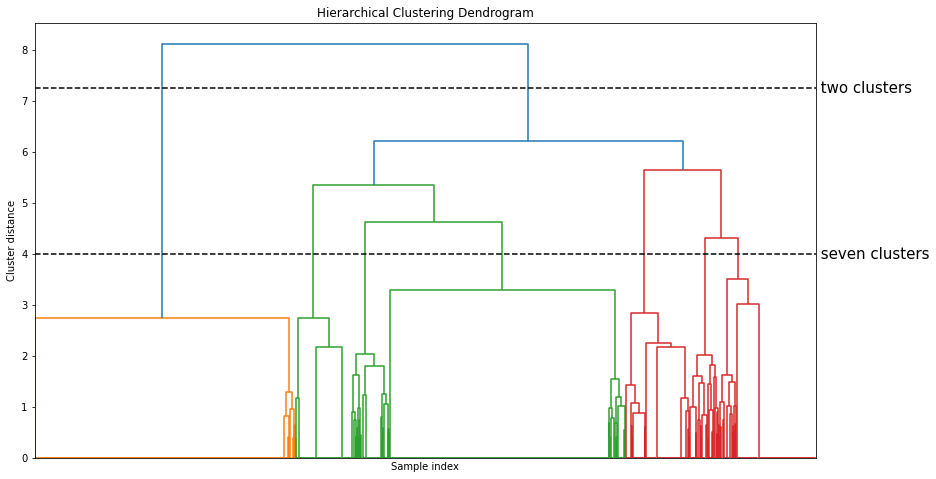

In [55]:
import numpy as np
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Assuming X is your user tags matrix
# Replace this with your actual data
X = matrix_games_tags_comp

# Normalize the data
X_normalized = normalize(X)

# Perform hierarchical clustering
linkage_matrix = linkage(X_normalized, method='ward')

# Increase the size of the plot by setting figsize
fig, ax = plt.subplots(figsize=(14, 8))


# Plot the dendrogram
dendrogram(linkage_matrix, labels=np.arange(1, len(X) + 1))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('User')
plt.ylabel('Distance')
plt.xticks(visible=False)

# Mark the cuts in the tree that signify two or three clusters
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [7.25, 7.25], '--', c='k')
ax.plot(bounds, [4, 4], '--', c='k')
ax.text(bounds[1], 7.25, ' two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 4, ' seven clusters', va='center', fontdict={'size': 15})
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")
plt.show()


In [65]:
num_clusters = 7

In [66]:
labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
labels

array([4, 4, 4, ..., 6, 1, 1], dtype=int32)

In [67]:
labels.shape

(1991,)

In [68]:
matrix_games_tags_comp["Cluster"] = labels

In [69]:
matrix_games_tags_comp

,Adventure,Driving,Horror,Management,RPG,Realistic,Romantic,Simulation,Strategy,War Muliplayer,Cluster
0,1,1,0,1,1,1,1,1,1,1,4
1,1,1,0,1,1,1,1,1,1,1,4
2,1,1,0,1,1,0,1,1,0,1,4
3,1,1,0,1,1,1,1,1,1,1,4
4,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1986,1,1,0,1,1,1,1,1,1,1,4
1987,1,1,0,1,1,1,1,1,1,1,4
1988,1,1,0,1,0,1,0,1,1,1,6
1989,1,1,1,1,1,1,1,1,1,1,1


In [70]:
matrix_games_tags_clus = matrix_games_tags_comp.groupby("Cluster").sum()
matrix_games_tags_clus

,Adventure,Driving,Horror,Management,RPG,Realistic,Romantic,Simulation,Strategy,War Muliplayer
Cluster,,,,,,,,,,
1,666.0,663.0,651.0,663.0,666.0,660.0,666.0,666.0,666.0,635.0
2,141.0,109.0,49.0,141.0,141.0,0.0,141.0,141.0,141.0,141.0
3,98.0,79.0,17.0,0.0,93.0,68.0,87.0,92.0,96.0,97.0
4,601.0,590.0,16.0,599.0,600.0,595.0,597.0,601.0,558.0,600.0
5,163.0,113.0,49.0,162.0,163.0,138.0,0.0,160.0,163.0,157.0
6,76.0,45.0,21.0,67.0,0.0,59.0,60.0,72.0,67.0,73.0
7,246.0,20.0,63.0,242.0,236.0,246.0,230.0,201.0,245.0,246.0


<AxesSubplot:xlabel='Cluster'>

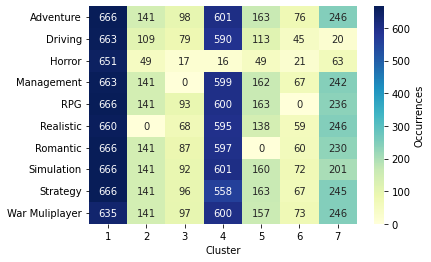

In [71]:
sns.heatmap(matrix_games_tags_clus.T, annot=True, cmap="YlGnBu", fmt="g", cbar_kws={'label': 'Occurrences'})

## Applying Word2Vec to Gaems-Tag (An exploration)

In [63]:
# !pip install gensim

In [64]:
game_tags = list(matrix_games_tags.columns)

# Load Word2Vec model
sentences = [tag.split() for tag in game_tags]
model = Word2Vec(sentences, vector_size=20, window=5, min_count=1, workers=4)

# Get vectors for each tag, handling out-of-vocabulary cases
tag_vectors = [model.wv[tag] if tag in model.wv else np.zeros(model.vector_size) for tag in game_tags]

# Standardize the data
scaler = StandardScaler()
tag_vectors_standardized = scaler.fit_transform(tag_vectors)

# Specify the number of clusters
num_clusters = 10

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
tag_clusters = kmeans.fit_predict(tag_vectors_standardized)

# Print the clusters for each tag
for tag, cluster in zip(game_tags, tag_clusters):
    print(f"{tag}: Cluster {cluster}")

tag_cluster_df = pd.DataFrame([tag_clusters], columns=game_tags).T\
                .reset_index()\
                .rename({0:"Cluster", "index":"Tag"}, axis=1)
tag_cluster_df.head()

C:\Users\riccardoricci\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
tag_cluster_df[tag_cluster_df["Cluster"]==0]

,Tag,Cluster
43,BMX,0
86,Combat,0
99,Crime,0
110,Deckbuilding,0
117,Diplomacy,0
134,Episodic,0
150,First-Person,0
187,Hunting,0
235,Minimalist,0
237,Mod,0


In [ ]:
# matrix_games_tags[matrix_games_tags["user_id_categorical"]==0]